In [1]:
#Partially adopted from Tensorflow/docs/basic_text_classification

#https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/basic_text_classification.ipynb

In [2]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import numpy as np

print(tf.__version__)

import nltk
nltk.download('punkt')
from nltk import word_tokenize
stemmer = nltk.stem.SnowballStemmer('english')

1.11.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#MAPPING SENTENCES TO LIBRARY
import json
word_index = keras.datasets.imdb.get_word_index()

#declare trainData as an empty list
trainData = []
trainLabels = []

nonfunctional = 0
functional = 0
    
#temp list for each sentence
tempList = []

#Keeping track of used requirement statements
func = []
nonfunc = []

#this is the number of unique functional requirements in the data
LIMIT = 1361

with open("Consolidated_data.txt","r") as f, open("libraryStemmed.json", "r") as l:
    data = json.load(l)

    #Go line by line in original data file
    for line in f:
        #find where class begins
        front = line.find("\"class\":\"")
        #find where class ends (where sentence begins)
        end = line.find("\",\"sentence\":\"")
        #substring line based on front and end above
        reqClass = (line[(front+9):end]).lower()

        #sentence
        del tempList[:]
        temp = line.find("\"sentence\":\"")
        sentence = (line[(temp+12):-4]).lower()
        sentence = sentence.translate(None, '.,-\":;~!@#$%^&?[]{}<>`1234567890\\*()').strip()
        
        #check for nonfunc. keyword
        if "nonfunctional" in reqClass and (nonfunctional < LIMIT):
            #if it was already used, disregard it
            if sentence in func:
                continue
            nonfunc.append(sentence)
            nonfunctional +=1
            trainLabels.append(0)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                #if word found in library, add corresponding value to the array
                if x in data:
                    tempList.append(data[x])
                #if word is not found, append 1 (<UNK> flag)
                else:
                    tempList.append(1)
            trainData.append(tempList[:])
        elif "functional" in reqClass and (functional < LIMIT):
            #if it was already used, disregard it
            if sentence in nonfunc:
                continue
            func.append(sentence)
            functional +=1
            trainLabels.append(1)
            for x in sentence.split(' '):
                x = unicode(x, 'utf-8')
                x = stemmer.stem(x)
                if x in data:
                    tempList.append(data[x])
                else:
                    tempList.append(1)
            trainData.append(tempList[:])
        else:
            if (nonfunctional < LIMIT):
                #if it was already used, disregard it
                if sentence in func:
                    continue
                nonfunc.append(sentence)
                nonfunctional +=1
                trainLabels.append(0)
                for x in sentence.split(' '):
                    x = unicode(x, 'utf-8')
                    x = stemmer.stem(x)
                    if x in data:
                        tempList.append(data[x])
                    else:
                        tempList.append(1)
                trainData.append(tempList[:])


In [4]:
#randomizing data in two arrays without disrupting the order
trainData, trainLabels = shuffle(trainData, trainLabels)

In [5]:
#Taking a chunk of test data from the main dataset
testData = []
testLabels = []

#keeping track of how many requirements of each type there are
nonfunctional = 0
functional = 0

#this number represents of how many func. and nonfunc. requirements
#will be chopped off the training dataset
#(total is multiplied by 2)
testDataNumber = 200

for x in trainLabels:
    if x == 1 and functional < testDataNumber:
        functional += 1
        testData.append(trainData.pop(0))
        testLabels.append(trainLabels.pop(0))
    else:
        if x == 0 and nonfunctional < testDataNumber:
            nonfunctional += 1
            testData.append(trainData.pop(0))
            testLabels.append(trainLabels.pop(0))

In [6]:
#sanity check
#checking if there is more of less an even amount of func. and nonfunc. requirements in both datasets
print(trainLabels.count(1))
print(trainLabels.count(0))
print(testLabels.count(1))
print(testLabels.count(0))

1174
1148
187
213


In [7]:
#randomizing data in two arrays without disrupting the order
testData, testLabels = shuffle(testData, testLabels)

In [8]:
#sanity check
#those should NOT be the same
print testData[0]
print trainData[0]

[1, 1, 1, 73, 1, 1, 143, 249, 12, 1, 70, 1, 1, 222]
[1, 9, 12, 83, 1, 42, 1, 229]


In [9]:
# A dictionary mapping words to an integer index
word_index = json.load(open('libraryStemmed.json', 'r'))

word_index["<PAD>"] = 0
word_index["<UNK>"] = 1 # unknown

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#function that decodes array of numbers into original requirement tezt
def decode_requirement(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [10]:
print(decode_requirement(trainData[0]))
print(trainLabels[0])

<UNK> system shall allow <UNK> report <UNK> except
1


In [11]:
#Preprocessing train and test datasets to have equal max-length
#since vector multiplication only works with the vectors of equal lengths
#Optimal length is 32 (by trial and error)
trainData = keras.preprocessing.sequence.pad_sequences(trainData,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=32)

testData = keras.preprocessing.sequence.pad_sequences(testData,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=32)

In [12]:
#even though there are ~3000 unique stemmed words in the dataset,
#we use only first 2000 (excluding stopwords) in order to not mislead the model
#with rare occuring words
vocab_size = 2005

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          32080     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 32,369
Trainable params: 32,369
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
#We take as many samples for training as we can
#In this case, we only leave 200 for validation set
x_val = trainData[2122:]
partial_x_train = trainData[:2122]

y_val = trainLabels[2122:]
partial_y_train = trainLabels[:2122]

In [15]:
#Sanity check
#This should produce accuracy of around .5
print(model.evaluate(testData, testLabels))

400/400 [==============================] - 0s 287us/step
[0.6928424644470215, 0.5275]


In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=50,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 2122 samples, validate on 200 samples
Epoch 1/50
2122/2122 [==============================] - 0s 153us/step - loss: 0.6927 - acc: 0.5184 - val_loss: 0.6918 - val_acc: 0.5600
Epoch 2/50
2122/2122 [==============================] - 0s 16us/step - loss: 0.6914 - acc: 0.5702 - val_loss: 0.6908 - val_acc: 0.5450
Epoch 3/50
2122/2122 [==============================] - 0s 15us/step - loss: 0.6902 - acc: 0.5763 - val_loss: 0.6896 - val_acc: 0.5600
Epoch 4/50
2122/2122 [==============================] - 0s 14us/step - loss: 0.6888 - acc: 0.5782 - val_loss: 0.6885 - val_acc: 0.5550
Epoch 5/50
2122/2122 [==============================] - 0s 14us/step - loss: 0.6874 - acc: 0.5844 - val_loss: 0.6873 - val_acc: 0.5750
Epoch 6/50
2122/2122 [==============================] - 0s 16us/step - loss: 0.6857 - acc: 0.5961 - val_loss: 0.6860 - val_acc: 0.5750
Epoch 7/50
2122/2122 [==============================] - 0s 16us/step - loss: 0.6840 - acc: 0.6084 - val_loss: 0.6845 - val_acc: 0.5750
Epoch 8

In [17]:
#Evalueating model on the testset
print(model.evaluate(testData, testLabels))

400/400 [==============================] - 0s 40us/step
[0.5415411865711213, 0.725]


In [18]:
#The rest of the notebook helps vidualize losses and accuracies by ploting two separate grophs
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

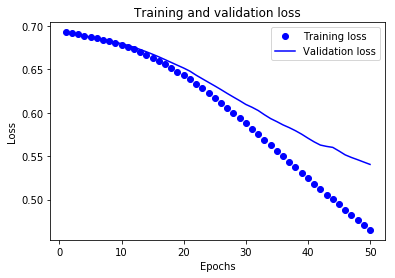

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

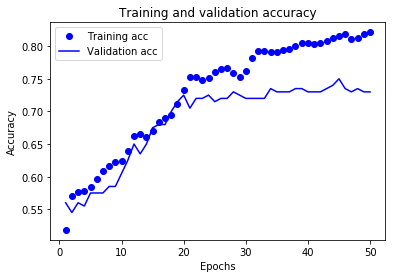

In [20]:
plt.clf() #clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()